## Imports

In [1]:
import numpy as np
from sklearn import datasets
from JOPLEn.singletask import JOPLEn
from JOPLEn.enums import *
from sklearn.ensemble import (
    ExtraTreesRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression
from lineartree import (
    LinearForestRegressor,
    LinearBoostRegressor,
)
from JOPLEn.ablation import Booster
import lineartree as lt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor, DummyClassifier
from itertools import product
import warnings
from collections import defaultdict
from linear_operator.utils.warnings import NumericalWarning
from sklearn.linear_model import Ridge

# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)
# Ax gives warning about non PSD matrix.
# TODO: Should I fix this?
warnings.simplefilter(action="ignore", category=NumericalWarning)
from ax import optimize
from pathlib import Path
from copy import copy, deepcopy
import yaml
import time
from pprint import pprint
from ax.service.ax_client import AxClient, ObjectiveProperties
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER
from JOPLEn.partitioner import VPartition
from JOPLEn.enums import CellModel
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)

CACHE_DIR = Path("ax_runs")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DS_PATH = Path("..") / "datasets" / "pmlb" / "processed"
PARAM_PATH = Path(".") / "parameters"
PLOT_PATH = Path(".") / "plots"


In [2]:
# too many samples, causes JOPLEn to crash
EXCLUDE = [
    "1191_BNG_pbc",
    "215_2dplanes",
    "1201_BNG_breastTumor",
    "1196_BNG_pharynx",
    "1595_poker",
    "1203_BNG_pwLinear",
    "594_fri_c2_100_5",
    "218_house_8L",
    "1193_BNG_lowbwt",
    "537_houses",
    "564_fried",
    "344_mv",
    "574_house_16H",
    # 10000 estimators
    "225_puma8NH",
    "529_pollen",
    "622_fri_c2_1000_50",
    "banana",
]


## Parameters

In [3]:
model_info = {}

for file in PARAM_PATH.glob("*.yaml"):
    model_info[file.stem] = yaml.safe_load(open(file, "r"))


## Training Functions

In [4]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time

        return (result, start_time, end_time, elapsed_time)

    return wrapper


@timer_decorator
def train_lgbm(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    model = LGBMRegressor(**params)
    model.fit(
        x_train,
        y_train.flatten(),
        # TODO: Need to re-enable validation set
        eval_set=[(x_val, y_val.flatten())],
        # verbose=-1,
        callbacks=[],
    )

    val_error = float(rmse(y_val.flatten(), model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test.flatten(), model.predict(x_test)))
        return val_error, test_error, model, None
    else:
        return val_error, model


@timer_decorator
def train_sklearn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    rescale=False,
):
    if rescale:
        model = Pipeline(
            [("scaler", StandardScaler()), ("model", ModelClass(**params))]
        )
    else:
        model = ModelClass(**params)
    model.fit(x_train, y_train.flatten())

    val_error = float(rmse(y_val.flatten(), model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test.flatten(), model.predict(x_test)))
        return val_error, test_error, model, None
    else:
        return val_error, model


def train_gbr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        GradientBoostingRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_rfr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        RandomForestRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_etr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        ExtraTreesRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_lb(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        LinearBoostRegressor,
        {**params, "base_estimator": LinearRegression()},
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_lf(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        LinearForestRegressor,
        {**params, "base_estimator": LinearRegression()},
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_ridge(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        Ridge,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        rescale=True,
    )


@timer_decorator
def train_pen(
    ModelType,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    params = deepcopy(params)

    initial_params = {
        "partitioner": eval(params.pop("partitioner")),
        "n_cells": params.pop("n_cells"),
        "n_partitions": params.pop("n_partitions"),
        "random_state": params.pop("random_state"),
    }

    if "cell_model" in params:
        initial_params["cell_model"] = eval(params.pop("cell_model"))

    model = ModelType(**initial_params)

    if "norm_type" in params:
        params["norm_type"] = eval(params["norm_type"])

    history = model.fit(
        x_train,
        y_train,
        val_x=x_val,
        val_y=y_val,
        **params,
    )

    val_error = float(rmse(y_val, model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test, model.predict(x_test)))
        return val_error, test_error, model, {"n_epochs": len(history["objective"])}
    else:
        return val_error, model


def train_joplen(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_pen(JOPLEn, params, x_train, y_train, x_val, y_val, x_test, y_test)


def train_booster(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_pen(Booster, params, x_train, y_train, x_val, y_val, x_test, y_test)


In [5]:
def dummy_regressor(x_train, x_val, x_test, y_train, y_val, y_test, indent=False):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train)
    y_pred = dummy.predict(x_test)

    res = {
        "model_name": dummy.__class__.__name__,
        "rmse": float(rmse(y_test, y_pred)),
    }

    return res


## Run Experiments

In [6]:
def contains_categorical(arr: np.ndarray) -> bool:
    """Checks if an array contains categorical, ordinal, binary, or nominal features"""
    return np.any(np.all(np.mod(arr, 1) == 0, axis=0))


train_fn = {
    LGBMRegressor.__name__: train_lgbm,
    GradientBoostingRegressor.__name__: train_gbr,
    RandomForestRegressor.__name__: train_rfr,
    ExtraTreesRegressor.__name__: train_etr,
    JOPLEn.__name__: train_joplen,
    LinearBoostRegressor.__name__: train_lb,
    LinearForestRegressor.__name__: train_lf,
    Booster.__name__: train_booster,
    Ridge.__name__: train_ridge,
}


def optimize_model(model_info, ds_path, n_trials, minimize, loss_type, overwrite=False):
    ds_name = ds_path.name
    params = model_info["parameters"]

    dir_path = CACHE_DIR / model_info["dir_name"] / ds_name
    exp_path = dir_path / "experiment.json"
    metadata_path = dir_path / "metadata.yaml"

    if metadata_path.exists() and not overwrite:
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)
        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    if contains_categorical(x_train):
        return None

    dummy_info = dummy_regressor(
        x_train, x_val, x_test, y_train, y_val, y_test, indent=True
    )

    if not exp_path.exists() or overwrite:
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=f"{model_info['model']}_{ds_name}",
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=minimize)},
            overwrite_existing_experiment=True,
        )

        for _ in range(n_trials):
            round_params, trial_index = ax_client.get_next_trial()

            try:
                val_error, _ = train_fn[model_info["model"]](
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                )[0]
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=float(val_error)
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(filepath=exp_path)

    best_parameters, values = ax_client.get_best_parameters()

    (val_error, test_error, _, metadata), _, _, train_time = train_fn[
        model_info["model"]
    ](
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    metadata = {
        "model_name": model_info["model"],
        "val_score": float(val_error),
        "test_score": float(test_error),
        "train_time": float(train_time),
        "params": best_parameters,
        "dummy_loss": float(dummy_info["rmse"]),
        **metadata,
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata


In [7]:
reg_datasets = [d for d in (DS_PATH / "reg").iterdir() if d.is_dir()]

reg_res = defaultdict(dict)

itr = tqdm(reg_datasets)

for ds_path in itr:
    if ds_path.name in EXCLUDE:
        continue

    for file_name, info in model_info.items():
        model_str = f"{file_name} on {ds_path.name}"
        itr.set_description(f"Running {model_str : <50}")
        res = optimize_model(info, ds_path, 50, True, "rmse")

        if res is not None:
            reg_res[info["name"]][ds_path.name] = res

reg_res = dict(reg_res)

# Only use datasets that are in reg_res["JOPLEn"]
reg_res = {
    k: {kk: vv for kk, vv in v.items() if kk in reg_res["JOPLEn (linear 1k)"]}
    for k, v in reg_res.items()
}


Running joplen_linear_low on 653_fri_c0_250_25            :  16%|█▌        | 19/122 [06:35<35:44, 20.82s/it] 


KeyboardInterrupt: 

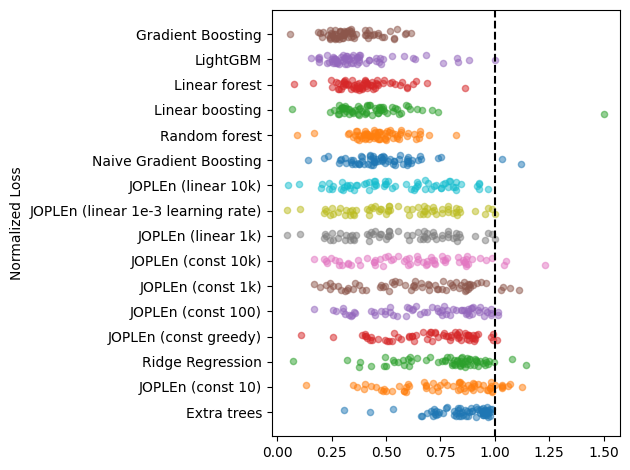

In [ ]:
def plot_strip(
    arr: list[np.ndarray], jitter: float = 0.2, random_state: int = 0, **kwargs
):
    """
    Create a strip plot based on the list of y-values.
    """
    fig, ax = plt.subplots()

    for x_idx, x_values in enumerate(arr):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
        ax.scatter(x_values, y_values, **kwargs)

    return ax


x_values = []
y_labels = []

# reg_res = {k: reg_res[k] for k in sorted(reg_res.keys())}
rescaled_res = {
    k: {kk: (vv["test_score"] / vv["dummy_loss"]) for kk, vv in v.items()}
    for k, v in reg_res.items()
}

mean_res = {k: np.mean(list(v.values())) for k, v in rescaled_res.items()}

sorted_dict = {k: rescaled_res[k] for k in sorted(mean_res, key=mean_res.get)[::-1]}

for k, v in sorted_dict.items():
    x_values.append(v.values())
    y_labels.append(k)

ax = plot_strip(x_values, alpha=0.5, s=20)

ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)

y_lim, x_lim = ax.get_ylim(), ax.get_xlim()
ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")
ax.set_ylim(y_lim)
ax.set_xlim(x_lim)

plt.ylabel("Normalized Loss")

plt.tight_layout()
plt.savefig(PLOT_PATH / "reg_strip.png", dpi=300)

plt.show()


In [ ]:
method1 = "Gradient Boosting"
method2 = "JOPLEn (linear)"

# ensure that the datasets are in the same order
sorted_keys = sorted(reg_res[method1].keys())

ds1, ds2 = [], []

for k in sorted_keys:
    ds1.append(reg_res[method1][k]["test_score"] / reg_res[method1][k]["dummy_loss"])
    ds2.append(reg_res[method2][k]["test_score"] / reg_res[method2][k]["dummy_loss"])

plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.scatter(ds1, ds2)

plt.xlabel(method1)
plt.ylabel(method2)

plt.title("Normalized Loss (lower is better)")


KeyError: 'JOPLEn (linear)'